### Sketch of BHC Algorithm

In [2]:
import numpy as np
import sklearn.datasets as ds
import scipy.linalg as la
from scipy import random as rnd
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd

#### Test Data

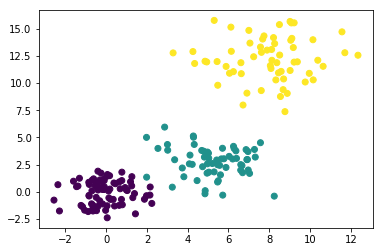

In [3]:
# Example data will consist of a mixture of three gaussian distributions with varying parameters. It will be clustered via random draws of a multinomial distribution.

# bivariate gaussian params

mu1 = np.zeros(2)
cov1 = np.eye(2)

mu2 = np.array([5, 3])
cov2 = np.eye(2) * 2

mu3 = np.array([8, 12])
cov3 = np.array([3.4, 0, 0, 5.1]).reshape(2, 2)

# multinom params

p1 = 0.4
p2 = 0.3
p3 = 1 - p2 - p1

# number of total draws
draws = 200

# random draws
rnd.seed(11561)

knum = rnd.multinomial(draws, (p1, p2, p3))

gaus1 = rnd.multivariate_normal(mu1, cov1, knum[0])
gaus2 = rnd.multivariate_normal(mu2, cov2, knum[1])
gaus3 = rnd.multivariate_normal(mu3, cov3, knum[2])

# join columns into dataframe

x1 = pd.Series(np.r_[gaus1[:, 0], gaus2[:, 0], gaus3[:, 0]])
x2 = pd.Series(np.r_[gaus1[:, 1], gaus2[:, 1], gaus3[:, 1]])

c = pd.Series(np.r_[np.zeros(knum[0]), np.ones(knum[1]), np.ones(knum[2]) * 2])
dat = {"x1" : x1, "x2" : x2, "c" : c}

data = pd.DataFrame(dat)

plt.scatter(data["x1"], data["x2"], c = data["c"])
plt.show()

#### Script

In [4]:
# initialize clusters
n = data.shape[0]
c = n

# initialize priors
prior_mu = np.array([np.mean(data.x1), np.mean(data.x2)])
prior_cov = np.cov(data.x1, data.x2)

# find pair of points with highest probability to merge
merge_prob = np.zeros(n)
c_assign = np.zeros((n, n)) # cluster assignments
c_assign[:,0] = np.arange(0,c) # initially each cluster is 1 data point

# initialize means
data_matrix = np.array(data.iloc[:,1:])

c_means = {}
for i in range(len(data_matrix)):
    c_means[i] = data_matrix[i,:]

# initialize covariance
c_cov = {}
for i in range(len(data_matrix)):
    c_cov[i] = np.identity(data_matrix.shape[1])

In [5]:
a = np.array([c_means[4]])
np.mean(a, axis=0)

array([0.2974389, 0.       ])

In [6]:
# iterate through each cluster
h0 = np.zeros((c,2))
for i in range(10):
    for j in range(c):
        # dummy likelihood for now
        h0[i,0] = i
        cluster_i = np.array([c_means[i]]) 
        h0[i,1] = np.sum(stats.multivariate_normal.pdf(np.mean(cluster_i, axis=0), 
                                                       prior_mu, 
                                                       prior_cov))
    merge = h0.argmax(axis=0)
    
    # add merged clusters to dict element with same label
    c_means[i] = np.array([c_means[i] + c_means[merge[0]]])
    
    # delete the old cluster
    c_means.pop(merge[0])
    
    # need to record merge probability
    merge_prob[i] = merge[1]
    
    c -= 1 # one less cluster due to merge
    h0 = np.zeros((c,2)) # reset h0

In [8]:
merge

array([9, 9], dtype=int64)